# Models included

- Raw data
  - Naive Bayes, LightGBM, Isolation Forest

- Normed data
  - SVM, SGD, Naive Bayes, LightGBM, Isolation Forest, one-class SVM



In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import yfinance as yf
import talib
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.metrics import Precision, AUC


import scripts.feature as feat
import scripts.utility as util


# Single ticker

In [2]:
ticker = "TSLA"
df = yf.download(ticker, period="5y", interval="1d", progress=False)
df = df.drop(columns=["Adj Close"])


In [3]:
result_table = pd.DataFrame(columns=["train_recall", "train_precision", "train_f1", "train_fbeta",
                                     "val_recall", "val_precision", "val_f1", "val_fbeta"])


## Multi-category case


In [4]:
def single_class_report(y_true, y_pred, label):
    instance = np.where(y_true == label)[0]
    predict = np.where(y_pred == label)[0]
    correct = np.intersect1d(instance, predict) 

    precision = len(correct) / (len(predict))
    recall = len(correct) / (len(instance))
    
    def fbeta_score(b):
        return (1+b**2) * (precision * recall) / (b**2 * precision + recall)
    f1 = fbeta_score(b=1)
    fbeta = fbeta_score(b=0.5)  # 0.5 beta focus more on precision

    print(f"----- For Class {label} -----")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"f1_score: {f1}")
    print(f"f0.5_score: {fbeta}")

    return [recall, precision, f1, fbeta]


def quick_model_evaluation(model, X_train, y_train, X_val, y_val, label):
    model.fit(X_train, y_train)

    print("train set")
    y_pred = model.predict(X_train)
    train_result = single_class_report(y_train, y_pred, label=label)

    print("val set")
    y_pred = model.predict(X_val)
    val_result = single_class_report(y_val, y_pred, label=label)

    return np.round(train_result + val_result, 3)


def quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label):
    model.fit(X_train)

    # class 1 is normal, -1 is anomaly
    print("train set")
    y_pred = model.predict(X_train)
    y_pred = np.where(y_pred > 0, 0, 1)
    train_result = single_class_report(y_train, y_pred, label=label)

    print("val set")
    y_pred = model.predict(X_val)
    y_pred = np.where(y_pred > 0, 0, 1)
    val_result = single_class_report(y_val, y_pred, label=label)

    return np.round(train_result + val_result, 3)

def update_result_table(df, result, idx_name):
    new = pd.DataFrame(data=[result],
                       columns=["train_recall", "train_precision", "train_f1", "train_fbeta",
                                "val_recall", "val_precision", "val_f1", "val_fbeta"],
                       index=[idx_name])
    df = pd.concat([df, new])
    return df


In [5]:
class_type = "multi"

### Raw data

In [6]:
data_type = "raw"

In [7]:
X_train, y_train, X_val, y_val = feat.raw_dataset_pipeline(df, seq_len=None, extend=3)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(977, 100) (977,) (245, 100) (245,)
(array([0, 1, 2], dtype=int64), array([389, 112, 476], dtype=int64))
(array([0, 1, 2], dtype=int64), array([112,  53,  80], dtype=int64))


In [8]:
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import IsolationForest



In [9]:
# Build LightGBM model
params = {
    "objective": "multiclass",
    "num_class": 3,
    "metric": "multi_logloss",
    "learning_rate": 0.03,
    "num_leaves": 32,
    "verbose": -1,
    
}


model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 1.0
Precision: 1.0
f1_score: 1.0
f0.5_score: 1.0
val set
----- For Class 2 -----
Recall: 0.6
Precision: 0.3609022556390977
f1_score: 0.45070422535211263
f0.5_score: 0.39215686274509803


C:\Users\edton\AppData\Local\Temp\ipykernel_49516\1446241041.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new])


In [10]:
result_table

,train_recall,train_precision,train_f1,train_fbeta,val_recall,val_precision,val_f1,val_fbeta
multi_raw_LGBMClassifier,1.0,1.0,1.0,1.0,0.6,0.361,0.451,0.392


In [11]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.31092436974789917
Precision: 0.6218487394957983
f1_score: 0.4145658263305322
f0.5_score: 0.5182072829131652
val set
----- For Class 2 -----
Recall: 0.075
Precision: 0.4
f1_score: 0.1263157894736842
f0.5_score: 0.2142857142857143


### Normed data

In [12]:
data_type = "norm"

In [13]:
X_train, y_train, X_val, y_val = feat.norm_dataset_pipeline(df, seq_len=None, extend=3)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(977, 100) (977,) (245, 100) (245,)
(array([0, 1, 2], dtype=int64), array([389, 112, 476], dtype=int64))
(array([0, 1, 2], dtype=int64), array([112,  53,  80], dtype=int64))


In [14]:
model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 1.0
Precision: 1.0
f1_score: 1.0
f0.5_score: 1.0
val set
----- For Class 2 -----
Recall: 0.5625
Precision: 0.3629032258064516
f1_score: 0.4411764705882353
f0.5_score: 0.39062500000000006


In [15]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.31092436974789917
Precision: 0.6218487394957983
f1_score: 0.4145658263305322
f0.5_score: 0.5182072829131652
val set
----- For Class 2 -----
Recall: 0.075
Precision: 0.4
f1_score: 0.1263157894736842
f0.5_score: 0.2142857142857143


In [16]:
model = SGDClassifier(loss="log_loss")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.49789915966386555
Precision: 0.5197368421052632
f1_score: 0.5085836909871244
f0.5_score: 0.5152173913043477
val set
----- For Class 2 -----
Recall: 0.325
Precision: 0.26
f1_score: 0.2888888888888889
f0.5_score: 0.27083333333333337


In [17]:
model = SVC(kernel="rbf")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.8697478991596639
Precision: 0.5782122905027933
f1_score: 0.6946308724832214
f0.5_score: 0.6197604790419162
val set
----- For Class 2 -----
Recall: 0.725
Precision: 0.3493975903614458
f1_score: 0.4715447154471545
f0.5_score: 0.3897849462365592


## Binary case

In [18]:
class_type = "binary"

### Raw data

In [19]:
data_type = "raw"

In [20]:
X_train, y_train, X_val, y_val = feat.raw_dataset_pipeline(df, seq_len=None, extend=3)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

y_train = np.where(y_train <= 1, 0, 1)
y_val = np.where(y_val <= 1, 0, 1)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(977, 100) (977,) (245, 100) (245,)
(array([0, 1]), array([501, 476], dtype=int64))
(array([0, 1]), array([165,  80], dtype=int64))


In [21]:
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.03,
    "num_leaves": 32,
    "verbose": -1,
    
}
model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 1.0
Precision: 1.0
f1_score: 1.0
f0.5_score: 1.0
val set
----- For Class 1 -----
Recall: 0.5375
Precision: 0.3644067796610169
f1_score: 0.43434343434343425
f0.5_score: 0.38949275362318836


In [22]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.40336134453781514
Precision: 0.5944272445820433
f1_score: 0.4806007509386733
f0.5_score: 0.5429864253393664
val set
----- For Class 1 -----
Recall: 0.0875
Precision: 0.3888888888888889
f1_score: 0.14285714285714285
f0.5_score: 0.2302631578947368


In [23]:
# This wont be good enough as contamination too low in train
model = IsolationForest(contamination=0.5)
model_result = quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")


train set
----- For Class 1 -----
Recall: 0.5504201680672269
Precision: 0.5368852459016393
f1_score: 0.5435684647302904
f0.5_score: 0.5395387149917628
val set
----- For Class 1 -----
Recall: 0.3375
Precision: 0.32926829268292684
f1_score: 0.33333333333333337
f0.5_score: 0.33088235294117646


### Normed data

In [24]:
data_type = "norm"

In [25]:
X_train, y_train, X_val, y_val = feat.norm_dataset_pipeline(df, seq_len=None, extend=3)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

y_train = np.where(y_train <= 1, 0, 1)
y_val = np.where(y_val <= 1, 0, 1)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(977, 100) (977,) (245, 100) (245,)
(array([0, 1]), array([501, 476], dtype=int64))
(array([0, 1]), array([165,  80], dtype=int64))


In [26]:
model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 1.0
Precision: 1.0
f1_score: 1.0
f0.5_score: 1.0
val set
----- For Class 1 -----
Recall: 0.5
Precision: 0.37735849056603776
f1_score: 0.43010752688172044
f0.5_score: 0.39682539682539686


In [27]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.40336134453781514
Precision: 0.5944272445820433
f1_score: 0.4806007509386733
f0.5_score: 0.5429864253393664
val set
----- For Class 1 -----
Recall: 0.0875
Precision: 0.3888888888888889
f1_score: 0.14285714285714285
f0.5_score: 0.2302631578947368


In [28]:
model = SGDClassifier(loss="log_loss")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.44537815126050423
Precision: 0.5023696682464455
f1_score: 0.47216035634743875
f0.5_score: 0.4898336414048059
val set
----- For Class 1 -----
Recall: 0.7125
Precision: 0.35625
f1_score: 0.475
f0.5_score: 0.3958333333333333


In [29]:
model = SVC(kernel="rbf")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.5567226890756303
Precision: 0.7162162162162162
f1_score: 0.6264775413711584
f0.5_score: 0.6774028629856851
val set
----- For Class 1 -----
Recall: 0.2
Precision: 0.4
f1_score: 0.26666666666666666
f0.5_score: 0.33333333333333337


In [30]:
# This wont be good enough as contamination too low in train
model = IsolationForest(contamination=0.5)
model_result = quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.5399159663865546
Precision: 0.5266393442622951
f1_score: 0.533195020746888
f0.5_score: 0.5292421746293245
val set
----- For Class 1 -----
Recall: 0.4
Precision: 0.37209302325581395
f1_score: 0.38554216867469876
f0.5_score: 0.3773584905660377


In [31]:
model = OneClassSVM(kernel="rbf", nu=0.2)
model_result = quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.24369747899159663
Precision: 0.6010362694300518
f1_score: 0.3467862481315396
f0.5_score: 0.4647435897435897
val set
----- For Class 1 -----
Recall: 0.0625
Precision: 0.4166666666666667
f1_score: 0.10869565217391304
f0.5_score: 0.1953125


# Final results in heatmap

<Axes: >

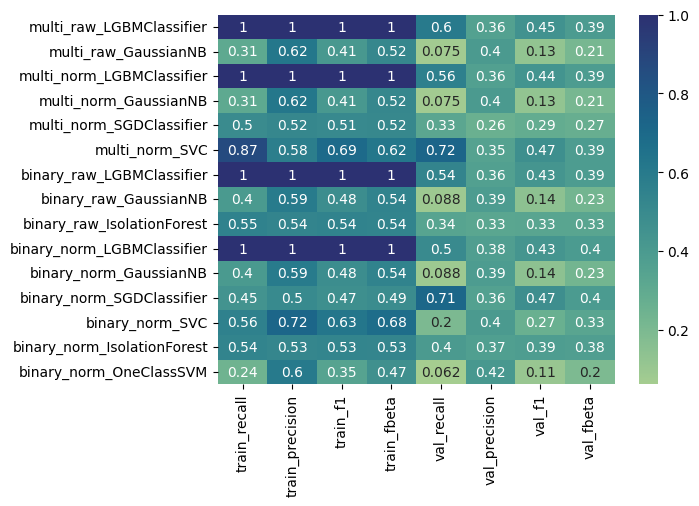

In [32]:
sns.heatmap(result_table, annot=True, cmap="crest")
